In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import en_vectors_web_lg
from IPython.display import display_markdown
from sklearn.model_selection import train_test_split

from shared import models
from shared.data import load_imdb
from shared.models_store import Store
from machine_learning.cache import get_preprocessed_data
from machine_learning.plot_helpers import display_example_predictions, describe_data
from machine_learning.evaluation import evaluate_and_report

Using TensorFlow backend.


In [2]:
nlp = en_vectors_web_lg.load()

In [3]:
MAX_WORDS_IN_SENTENCE = 300
LIMIT = -1
dataset_id = 'imdb_normalized_{}'.format(LIMIT if LIMIT > 0 else 'all')
SAVE_IN_STORE = True

In [4]:
print("Loading training data...")
X_train, y_train = load_imdb('../data/aclImdb/train', limit=LIMIT)

print("Loading test data...")
X_test, y_test = load_imdb('../data/aclImdb/test', limit=LIMIT)

Loading training data...
Loading test data...


In [5]:
describe_data(X_train, y_train, top_words=25)

display_markdown('### Train count: {}'.format(len(X_train)), raw=True)
display_markdown('### Test count:  {}'.format(len(X_test)), raw=True)

### Data sample

,X,y
0,"b""Dan Katzir has produced a wonderful film tha...",1
1,b'If you want Scream or anything like the big-...,1
2,"b""Outlandish premise that rates low on plausib...",0
3,b'Let\'s face it-- if you rented a STDVD seque...,0
4,b'Bizarre Tobe Hooper exercise regarding an un...,0
5,"b'Well, maybe the PC version of this game was ...",0
6,"b'Watching ""Kroko"" I would have liked to leave...",0
7,"b""First of all, I have to start this comment b...",1
8,"b""Very much a film from the times -- extremely...",0
9,"b'""The Invisible Ray"" is part science fiction ...",1


#### Text stats

count                                                 25000
unique                                                24904
top       b"How has this piece of crap stayed on TV this...
freq                                                      3
Name: X, dtype: object

#### Words length stats

count    25000.000000
mean       233.776720
std        173.715418
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: X, dtype: float64

#### Most frequent words

movie         30852
film          27757
like          18730
good          11890
it\'s          8751
story          8728
time           7923
great          7689
people         7662
/>the          7409
bad            6804
think          6764
little         6119
way            5806
<br            5724
watch          5700
best           5420
know           5334
seen           5330
love           5312
characters     5262
character      5259
movies         5246
movie.         4841
films          4822
dtype: int64

#### Labels stats

count    25000.00000
mean         0.50000
std          0.50001
min          0.00000
25%          0.00000
50%          0.50000
75%          1.00000
max          1.00000
Name: y, dtype: float64

#### Labels counts

1    12500
0    12500
Name: y, dtype: int64

1    0.5
0    0.5
Name: y, dtype: float64

### Train count: 25000

### Test count:  25000

In [6]:
# helper for saving models for reuse in web application

store = Store(nlp, '../dist/store.json')
input_samples = [
    "This movie is, in my opinion, very worth watching!",
    "I kinda liked that movie. Maybe it's not as good as other, but still watchable",
    "I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!",
]

def prefix(data, prefix=''):
    return {'{} {}'.format(prefix, k): v for k, v in data.items()}

def train_model_and_display_results(model, X, y, Xt, yt, **train_params):
    display_markdown('## {}'.format(model.__class__.__name__), raw=True)
    
    display_markdown("#### Overview of created model", raw=True)
    display(model.summary())

    display_markdown('#### Training', raw=True)
    model.load_or_train(X, y, **train_params)

    display_markdown('#### Model results', raw=True)
    display_example_predictions(model, input_samples)
    train_metrics, train_roc = evaluate_and_report(model, X, y, preprocessed=True)
    test_metrics, test_roc = evaluate_and_report(model, Xt, yt, preprocessed=True)
    return {
        'test': {'metrics': test_metrics, 'roc': test_roc},
        'train': {'metrics': train_metrics, 'roc': train_roc}, 
    }

Loading cached data...
Loaded data from 'kerasmodel_imdb_normalized_all.h5'
Loading cached data...
Loaded data from 'kerasmodel_imdb_normalized_all_test.h5'


## KerasModel

#### Overview of created model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 298, 256)          230656    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 149, 256)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 147, 128)          98432     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 73, 128)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 71, 64)            24640     
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

None

#### Training

Loading model...
Model 'keras_imdb_normalized_all_fb2cf34a.h5' loaded


#### Model results

#### Predicted scores

,score,text
0,0.752425,"This movie is, in my opinion, very worth watching!"
1,0.813468,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.032056,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Classification report for keras

             precision    recall  f1-score   support

   Negative     0.9831    0.9150    0.9478     12500
   Positive     0.9205    0.9842    0.9513     12500

avg / total     0.9518    0.9496    0.9496     25000



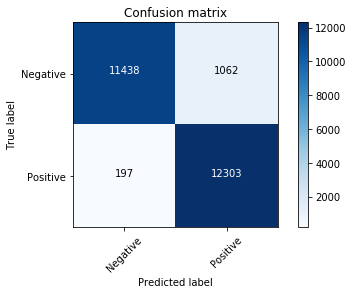

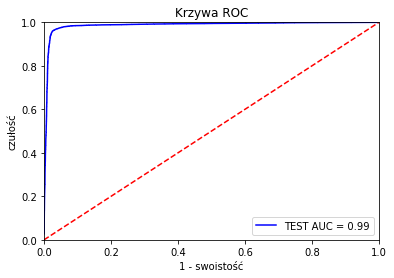

#### Classification report for keras

             precision    recall  f1-score   support

   Negative     0.9305    0.7749    0.8456     12500
   Positive     0.8071    0.9422    0.8694     12500

avg / total     0.8688    0.8585    0.8575     25000



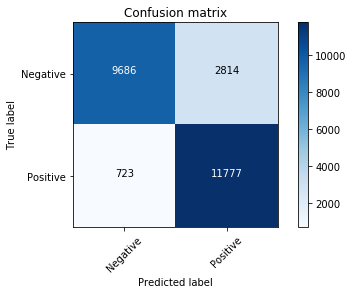

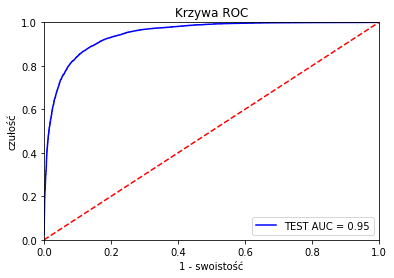

In [10]:
keras_model = models.KerasModel(
    nlp, 
    dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    epochs=10
)

X_keras_preprocessed = get_preprocessed_data(keras_model, dataset_id, X_train)
X_test_keras_preprocessed = get_preprocessed_data(keras_model, dataset_id + '_test', X_test)

data = train_model_and_display_results(
    keras_model, 
    X_keras_preprocessed, 
    y_train, 
    X_test_keras_preprocessed, 
    y_test, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(keras_model, "conv1d_imdb", "IMDB Conv1d", **data, metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_train),
        'Description': "1D Convolutional network defined using Keras and trained on a publicly-available dataset"
    })

## KerasExperimentalModel

#### Overview of created model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 298, 64)           57664     
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 296, 64)           12352     
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 294, 64)           12352     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 147, 64)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 145, 64)           12352     
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 143, 64)           12352     
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 141, 64)           12352     
__________

None

#### Training

Loading model...
Model 'keras_experimental_imdb_normalized_all_8396260f.h5' loaded


#### Model results

#### Predicted scores

,score,text
0,0.791593,"This movie is, in my opinion, very worth watching!"
1,0.625760,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.001107,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Classification report for keras_experimental

             precision    recall  f1-score   support

   Negative     0.9813    0.9286    0.9542     12500
   Positive     0.9322    0.9823    0.9566     12500

avg / total     0.9568    0.9554    0.9554     25000



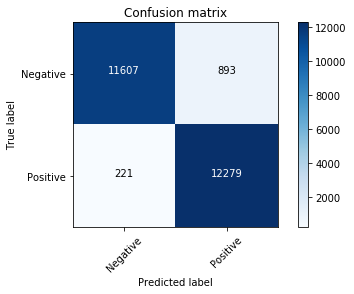

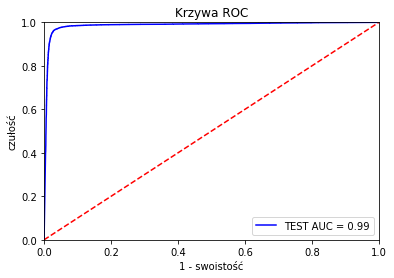

#### Classification report for keras_experimental

             precision    recall  f1-score   support

   Negative     0.9108    0.8017    0.8527     12500
   Positive     0.8229    0.9214    0.8694     12500

avg / total     0.8668    0.8616    0.8611     25000



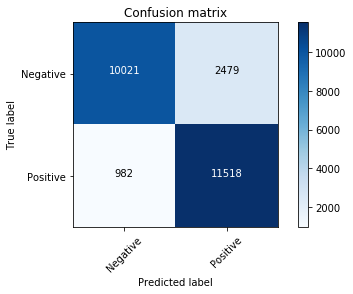

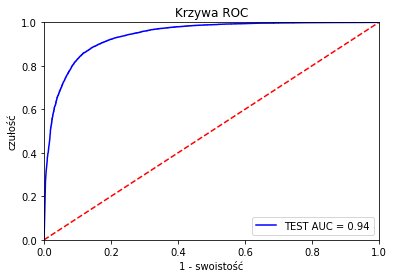

In [11]:
keras_model = models.KerasExperimentalModel(
    nlp, 
    dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    epochs=20
)

data = train_model_and_display_results(
    keras_model, 
    X_keras_preprocessed, 
    y_train, 
    X_test_keras_preprocessed, 
    y_test, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(keras_model, "conv1d_experiment_imdb", "IMDB Conv1d v2", **data, metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_train),
        'Description': "1D Convolutional network defined using Keras and trained on a publicly-available dataset"
    })


## KerasDeepModel

#### Overview of created model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 298, 96)           86496     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 149, 96)           0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 149, 96)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 147, 96)           27744     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 73, 96)            0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 73, 96)            0         
_________________________________________________________________
conv1d_27 (Conv1D)           (None, 71, 96)            27744     
__________

None

#### Training

Loading model...
Model 'keras_deep_imdb_normalized_all_8396260f.h5' loaded


#### Model results

#### Predicted scores

,score,text
0,0.539755,"This movie is, in my opinion, very worth watching!"
1,0.539755,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.539755,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Classification report for keras_deep

             precision    recall  f1-score   support

   Negative     0.8897    0.9746    0.9302     12500
   Positive     0.9719    0.8792    0.9232     12500

avg / total     0.9308    0.9269    0.9267     25000



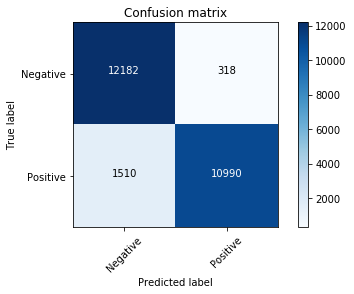

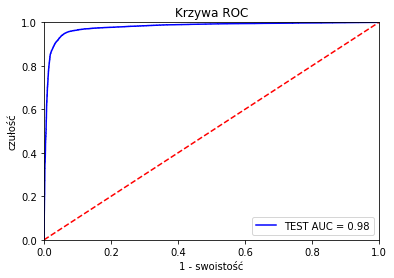

#### Classification report for keras_deep

             precision    recall  f1-score   support

   Negative     0.8081    0.9277    0.8638     12500
   Positive     0.9151    0.7798    0.8420     12500

avg / total     0.8616    0.8537    0.8529     25000



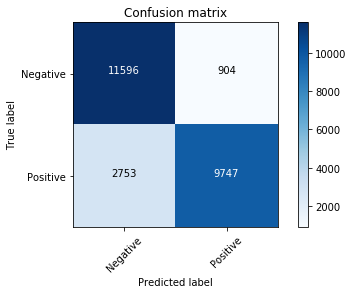

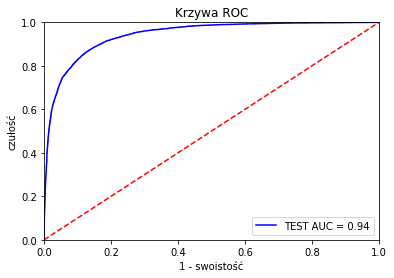

In [12]:
keras_model = models.KerasDeepModel(
    nlp, 
    dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    epochs=20
)

data = train_model_and_display_results(
    keras_model, 
    X_keras_preprocessed, 
    y_train, 
    X_test_keras_preprocessed, 
    y_test, 
    preprocessed=True
)


if SAVE_IN_STORE:
    store.add_model(keras_model, "conv1d_deep_imdb", "IMDB Conv1d Deep", **data, metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_train),
        'Description': "1D Convolutional network defined using Keras and trained on a publicly-available dataset"
    })

# we need memory for further processing
del X_keras_preprocessed
del X_test_keras_preprocessed

In [8]:
# preprocessed data for all sklearn-based models

model = models.SklearnModel(nlp, dataset_id, max_words_in_sentence=MAX_WORDS_IN_SENTENCE)
X_sklearn_preprocessed = get_preprocessed_data(model, dataset_id, X_train)
X_test_sklearn_preprocessed = get_preprocessed_data(model, dataset_id + '_test', X_test)


Loading cached data...
Loaded data from 'sklearnmodel_imdb_normalized_all.h5'
Loading cached data...
Loaded data from 'sklearnmodel_imdb_normalized_all_test.h5'


## SVCModel

#### Overview of created model

None

#### Training

Loading model...
Model 'svc_imdb_normalized_all_80e28a4f.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.985276,"This movie is, in my opinion, very worth watching!"
1,0.044972,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.069091,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Classification report for svc

             precision    recall  f1-score   support

   Negative     0.8162    0.8261    0.8211     10001
   Positive     0.8239    0.8139    0.8189      9999

avg / total     0.8200    0.8200    0.8200     20000



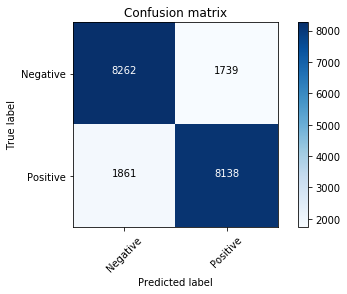

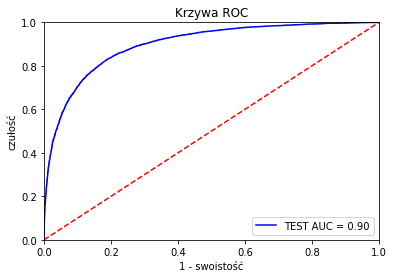

#### Classification report for svc

             precision    recall  f1-score   support

   Negative     0.8015    0.8273    0.8142     12500
   Positive     0.8215    0.7951    0.8081     12500

avg / total     0.8115    0.8112    0.8112     25000



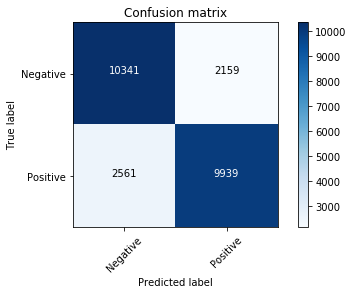

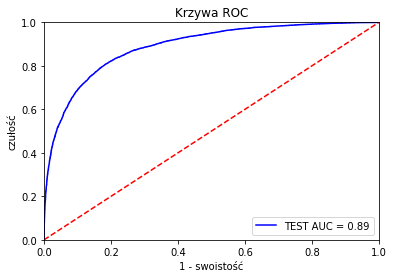

In [14]:
# it's almost impossible to train SVC on full dataset due to time complexity
svc_limit = min(20000, len(X_sklearn_preprocessed))
svc_model = models.SVCModel(
    nlp, dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    kernel="linear", C=0.025,
    probability=True)

data = train_model_and_display_results(
    svc_model,
    X_sklearn_preprocessed[:svc_limit],
    y_train[:svc_limit],
    X_test_sklearn_preprocessed,
    y_test,
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(svc_model, "svc_imdb", "IMDB SVC", **data, metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': svc_limit,
        'Description': "SVM algorithm from Sklearn package. Trained on a reduced dataset due to O(n^2) time complexity"
    }
)


## DecisionTreeModel

#### Overview of created model

None

#### Training

Loading model...
Model 'decisiontreeclassifier_imdb_normalized_all_5099b258.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.188235,"This movie is, in my opinion, very worth watching!"
1,0.211522,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.697248,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Classification report for decisiontreeclassifier

             precision    recall  f1-score   support

   Negative     0.7591    0.7274    0.7429     12500
   Positive     0.7383    0.7691    0.7534     12500

avg / total     0.7487    0.7483    0.7482     25000



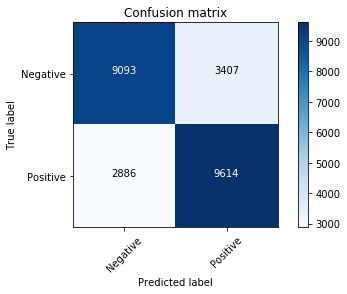

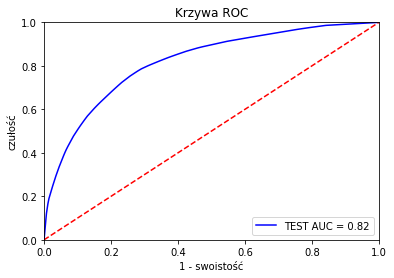

#### Classification report for decisiontreeclassifier

             precision    recall  f1-score   support

   Negative     0.7156    0.6909    0.7030     12500
   Positive     0.7012    0.7254    0.7131     12500

avg / total     0.7084    0.7082    0.7081     25000



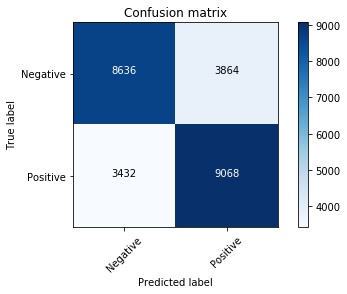

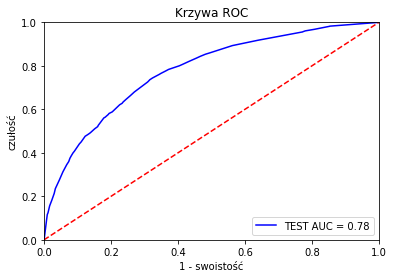

In [16]:
decision_tree_model = models.DecisionTreeModel(
    nlp, dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    max_depth=6
)

data = train_model_and_display_results(
    decision_tree_model, 
    X_sklearn_preprocessed, 
    y_train, 
    X_test_sklearn_preprocessed, 
    y_test, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(decision_tree_model, "decision_tree_imdb", "IMDB Decision Tree", **data, metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_sklearn_preprocessed),
        'Description': "Decision Tree algorithm from Sklearn package."
    })

## RandomForestModel

#### Overview of created model

None

#### Training

Loading model...
Unable to load model, training...


/srv/src/shared/models.py:104: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.model.fit(X, y, **train_params)


Model 'randomforestclassifier_imdb_normalized_all_5d984c39.pkl' saved


#### Model results

#### Predicted scores

,score,text
0,0.573543,"This movie is, in my opinion, very worth watching!"
1,0.341733,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.379435,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Classification report for randomforestclassifier

             precision    recall  f1-score   support

   Negative     0.8617    0.8830    0.8722     12500
   Positive     0.8800    0.8583    0.8690     12500

avg / total     0.8709    0.8706    0.8706     25000



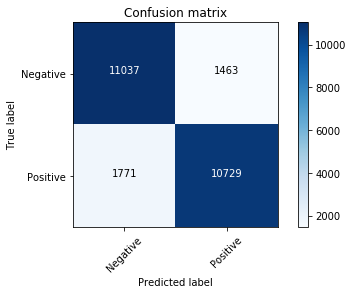

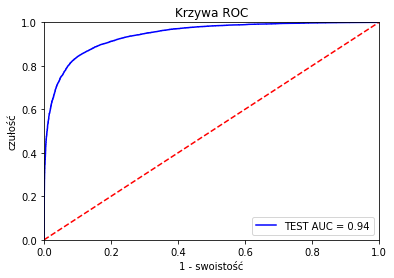

#### Classification report for randomforestclassifier

             precision    recall  f1-score   support

   Negative     0.7829    0.8006    0.7916     12500
   Positive     0.7960    0.7779    0.7869     12500

avg / total     0.7894    0.7893    0.7893     25000



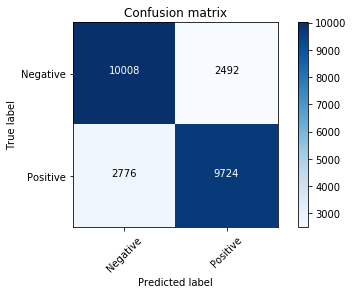

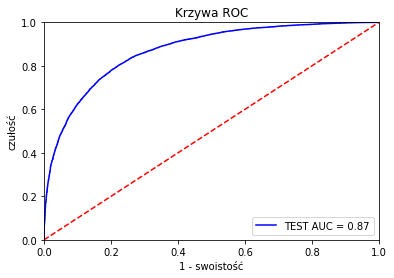

In [10]:
random_forest_model = models.RandomForestModel(
    nlp, dataset_id, 
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE,
    n_estimators=1000,
    max_depth=8,
    max_features=40
)

data = train_model_and_display_results(
    random_forest_model, 
    X_sklearn_preprocessed, 
    y_train, 
    X_test_sklearn_preprocessed, 
    y_test, 
    preprocessed=True
)


if False and SAVE_IN_STORE:
    store.add_model(random_forest_model, "random_forest_imdb", "IMDB Random Forest", **data, metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_sklearn_preprocessed),
        'Description': "Random Forest algorithm from Sklearn package."
    })

## MLPModel

#### Overview of created model

None

#### Training

Loading model...
Model 'mlpclassifier_imdb_normalized_all_0af5f423.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.999929,"This movie is, in my opinion, very worth watching!"
1,0.970518,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.589856,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Classification report for mlpclassifier

             precision    recall  f1-score   support

   Negative     0.9113    0.8688    0.8895     12500
   Positive     0.8746    0.9154    0.8946     12500

avg / total     0.8930    0.8921    0.8921     25000



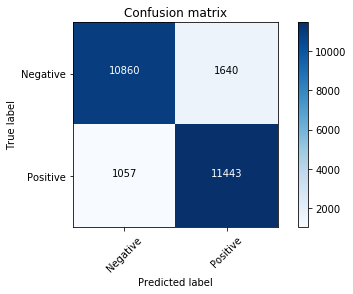

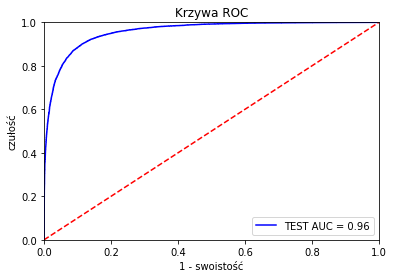

#### Classification report for mlpclassifier

             precision    recall  f1-score   support

   Negative     0.8582    0.8230    0.8402     12500
   Positive     0.8299    0.8640    0.8466     12500

avg / total     0.8441    0.8435    0.8434     25000



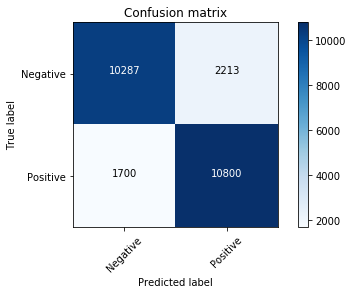

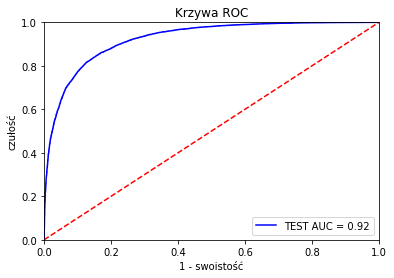

In [17]:
mlp_model = models.MLPModel(
    nlp, dataset_id,
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    hidden_layer_sizes=[50, 50], 
    max_iter=200, 
    verbose=True
)

data = train_model_and_display_results(
    mlp_model,
    X_sklearn_preprocessed, 
    y_train, 
    X_test_sklearn_preprocessed, 
    y_test, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(mlp_model, "mlp_imdb", "IMDB Multi-Layer Perceptron", **data, metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_sklearn_preprocessed),
        'Description': "MLP algorithm from Sklearn package, with 50x50 hidden layers sizes"
    })

## GaussianNBModel

#### Overview of created model

None

#### Training

Loading model...
Model 'gaussiannb_imdb_normalized_all_d41d8cd9.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,1.0,"This movie is, in my opinion, very worth watching!"
1,1.0,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,1.0,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Classification report for gaussiannb

             precision    recall  f1-score   support

   Negative     0.6867    0.7712    0.7265     12500
   Positive     0.7391    0.6482    0.6906     12500

avg / total     0.7129    0.7097    0.7086     25000



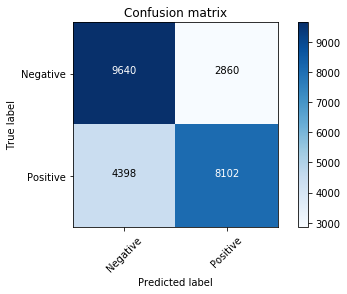

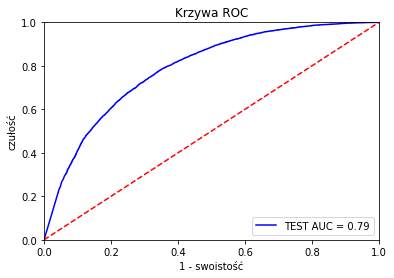

#### Classification report for gaussiannb

             precision    recall  f1-score   support

   Negative     0.6805    0.7638    0.7197     12500
   Positive     0.7308    0.6414    0.6832     12500

avg / total     0.7057    0.7026    0.7015     25000



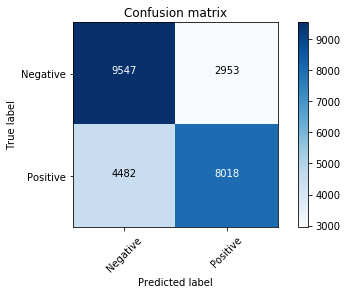

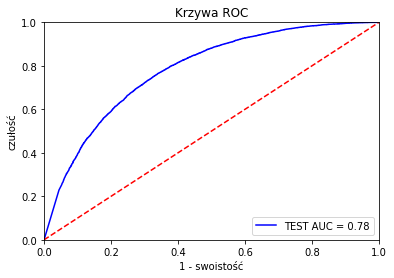

In [18]:
gaussian_nb_model = models.GaussianNBModel(
    nlp, dataset_id,
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
)

data = train_model_and_display_results(
    gaussian_nb_model,
    X_sklearn_preprocessed, 
    y_train, 
    X_test_sklearn_preprocessed, 
    y_test, 
    preprocessed=True
)


if SAVE_IN_STORE:
    store.add_model(gaussian_nb_model, "gnb_imdb", "IMDB Gaussian Naive Bayes", **data, metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_sklearn_preprocessed),
        'Description': "GaussianNB algorithm from Sklearn package, default options"
    })

## AdaBoostModel

#### Overview of created model

None

#### Training

Loading model...
Model 'adaboostclassifier_imdb_normalized_all_d41d8cd9.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.509433,"This movie is, in my opinion, very worth watching!"
1,0.489117,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.501522,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Classification report for adaboostclassifier

             precision    recall  f1-score   support

   Negative     0.8000    0.7995    0.7997     12500
   Positive     0.7996    0.8001    0.7999     12500

avg / total     0.7998    0.7998    0.7998     25000



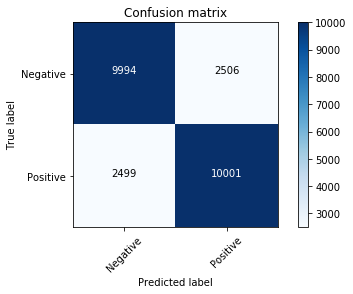

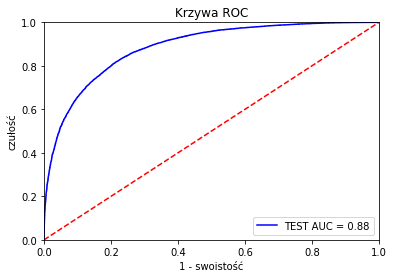

#### Classification report for adaboostclassifier

             precision    recall  f1-score   support

   Negative     0.7808    0.7922    0.7865     12500
   Positive     0.7892    0.7776    0.7833     12500

avg / total     0.7850    0.7849    0.7849     25000



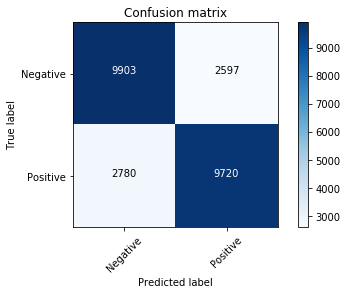

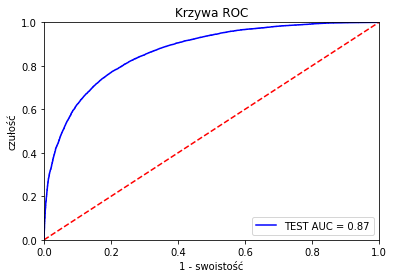

In [19]:
ada_boost_model = models.AdaBoostModel(
    nlp, dataset_id,
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
)

data = train_model_and_display_results(
    ada_boost_model,
    X_sklearn_preprocessed, 
    y_train, 
    X_test_sklearn_preprocessed, 
    y_test, 
    preprocessed=True
)


if SAVE_IN_STORE:
    store.add_model(ada_boost_model, "ada_imdb", "IMDB Ada Boost", **data, metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_sklearn_preprocessed),
        'Description': "Ada Boost algorithm from Sklearn package, default options"
    })

## QuadraticDiscriminantAnalysisModel

#### Overview of created model

None

#### Training

Loading model...
Model 'quadraticdiscriminantanalysis_imdb_normalized_all_d41d8cd9.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,1.000000,"This movie is, in my opinion, very worth watching!"
1,1.000000,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.024791,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Classification report for quadraticdiscriminantanalysis

             precision    recall  f1-score   support

   Negative     0.7849    0.9194    0.8468     12500
   Positive     0.9027    0.7480    0.8181     12500

avg / total     0.8438    0.8337    0.8325     25000



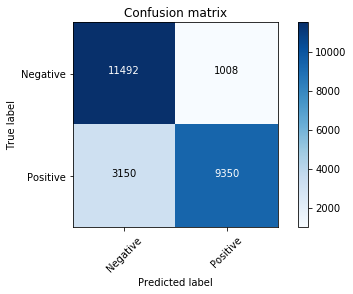

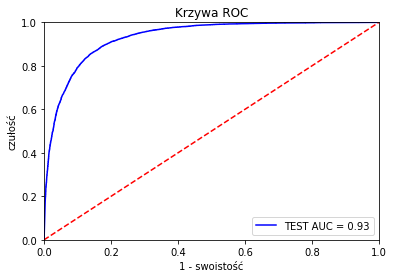

#### Classification report for quadraticdiscriminantanalysis

             precision    recall  f1-score   support

   Negative     0.6904    0.8203    0.7498     12500
   Positive     0.7787    0.6322    0.6978     12500

avg / total     0.7345    0.7262    0.7238     25000



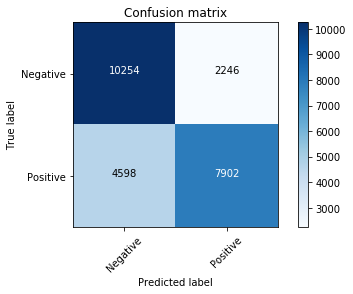

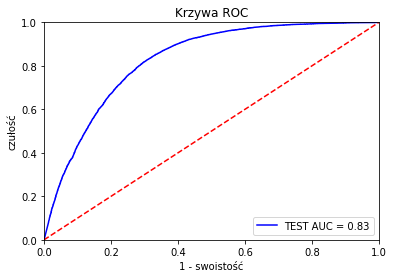

In [20]:
qda_model = models.QuadraticDiscriminantAnalysisModel(
    nlp, dataset_id,
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
)


data = train_model_and_display_results(
    qda_model,
    X_sklearn_preprocessed, 
    y_train, 
    X_test_sklearn_preprocessed, 
    y_test, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(qda_model, "qda_imdb", "IMDB Quadratic Discriminant Analysis", **data, metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_sklearn_preprocessed),
        'Description': "Quadratic Discriminant Analysis algorithm from Sklearn package, default options"
    })

## LogisticRegressionModel

#### Overview of created model

None

#### Training

Loading model...
Model 'logisticregression_imdb_normalized_all_90795899.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.998249,"This movie is, in my opinion, very worth watching!"
1,0.475775,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.098514,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Classification report for logisticregression

             precision    recall  f1-score   support

   Negative     0.8601    0.8575    0.8588     12500
   Positive     0.8580    0.8606    0.8593     12500

avg / total     0.8590    0.8590    0.8590     25000



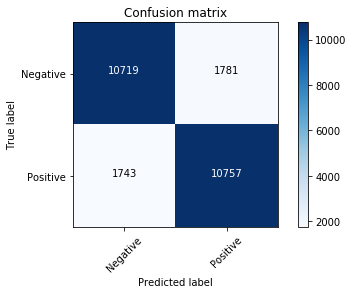

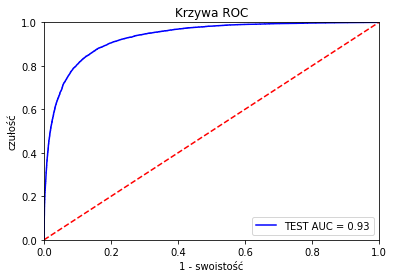

#### Classification report for logisticregression

             precision    recall  f1-score   support

   Negative     0.8448    0.8498    0.8473     12500
   Positive     0.8489    0.8439    0.8464     12500

avg / total     0.8469    0.8468    0.8468     25000



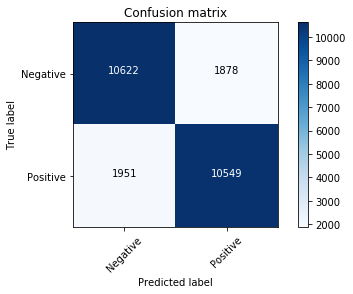

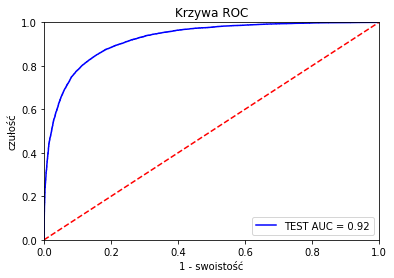

In [21]:
logistic_regression_limit = min(100000, len(X_sklearn_preprocessed))

logistic_regression = models.LogisticRegressionModel(
    nlp, dataset_id,
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    C=1e5
)

data = train_model_and_display_results(
    logistic_regression,
    X_sklearn_preprocessed[:logistic_regression_limit],
    y_train[:logistic_regression_limit],
    X_test_sklearn_preprocessed, 
    y_test, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(logistic_regression, "logistic_reg_imdb", "IMDB Logistic Regression", **data, metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': logistic_regression_limit,
        'Description': "Logistic Regression Analysis algorithm from Sklearn package, default options except C=1e5"
    })

## GradientBoostingModel

#### Overview of created model

None

#### Training

Loading model...
Model 'gradientboostingclassifier_imdb_normalized_all_c002d57a.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.619215,"This movie is, in my opinion, very worth watching!"
1,0.267174,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.308662,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Classification report for gradientboostingclassifier

             precision    recall  f1-score   support

   Negative     0.7943    0.7999    0.7971     12500
   Positive     0.7985    0.7928    0.7956     12500

avg / total     0.7964    0.7964    0.7964     25000



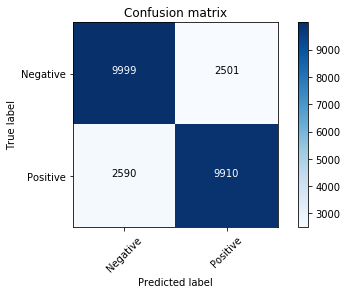

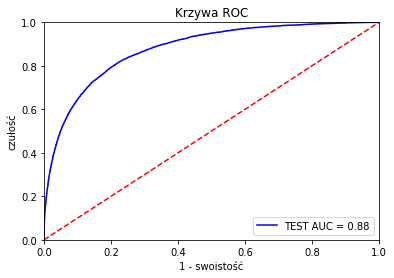

#### Classification report for gradientboostingclassifier

             precision    recall  f1-score   support

   Negative     0.7779    0.7889    0.7833     12500
   Positive     0.7858    0.7747    0.7802     12500

avg / total     0.7819    0.7818    0.7818     25000



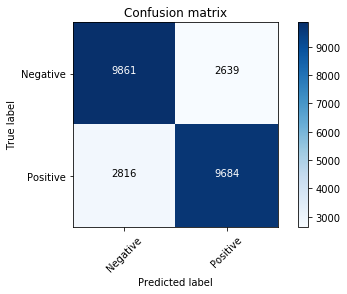

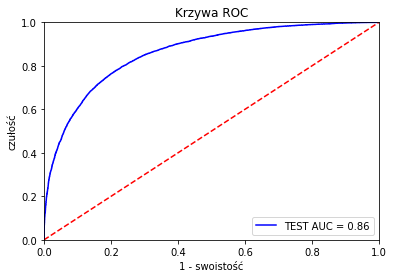

In [22]:
gradient_boosting_model = models.GradientBoostingModel(
    nlp, dataset_id,
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
    n_estimators=50, 
    max_depth=2,
    verbose=2
)

data = train_model_and_display_results(
    gradient_boosting_model,
    X_sklearn_preprocessed, 
    y_train, 
    X_test_sklearn_preprocessed, 
    y_test, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(gradient_boosting_model, "gradient_boost_imdb", "IMDB Gradient Boosting", **data, metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': len(X_sklearn_preprocessed),
        'Description': "Gradient Boosting algorithm from Sklearn package, n_estimators=50, max_depth=2"
    })

## XGBModel

#### Overview of created model

None

#### Training

Loading model...
Model 'xgbclassifier_imdb_normalized_all_5d69fa9f.pkl' loaded


#### Model results

#### Predicted scores

,score,text
0,0.726301,"This movie is, in my opinion, very worth watching!"
1,0.285321,"I kinda liked that movie. Maybe it's not as good as other, but still watchable"
2,0.459664,"I have to warn everybody, this movie is really bad. Actors don't know how to play. It su!*!"


#### Classification report for xgbclassifier

             precision    recall  f1-score   support

   Negative     0.8413    0.8427    0.8420     12500
   Positive     0.8425    0.8410    0.8417     12500

avg / total     0.8419    0.8419    0.8419     25000



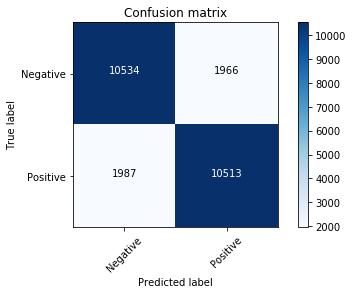

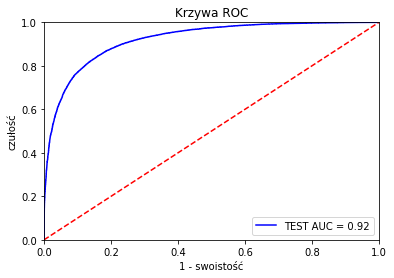

#### Classification report for xgbclassifier

             precision    recall  f1-score   support

   Negative     0.8070    0.8158    0.8114     12500
   Positive     0.8137    0.8050    0.8093     12500

avg / total     0.8104    0.8104    0.8104     25000



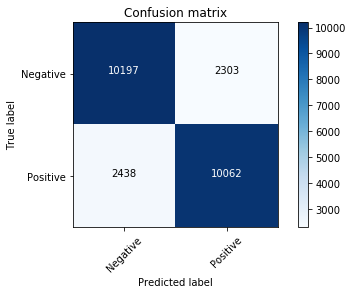

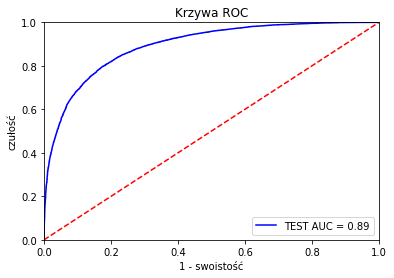

In [23]:
xgb_limit = min(50000, len(X_sklearn_preprocessed))
xgb_model = models.XGBModel(
    nlp, dataset_id, verbose_eval=1,
    max_words_in_sentence=MAX_WORDS_IN_SENTENCE, 
)

data = train_model_and_display_results(
    xgb_model,
    X_sklearn_preprocessed[:xgb_limit],
    y_train[:xgb_limit],
    X_test_sklearn_preprocessed, 
    y_test, 
    preprocessed=True
)

if SAVE_IN_STORE:
    store.add_model(xgb_model, "xgboost_imdb", "IMDB XGBoost", **data, metadata={
        'Dataset': 'Internet Movie Database',
        'Training samples': xgb_limit,
        'Description': "XGBoost using default parameters"
    })